In [29]:
import nltk
import requests
from nltk import word_tokenize
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from IPython.display import display, Markdown as md
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
import regex
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SKENNEDY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SKENNEDY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

def scale(array, scale_type='standard'):
    if scale_type == 'standard': #mean zero, std = 1
        return (array - np.mean(array))/np.std(array)
    if scale_type == 'min_max':
        return (array - np.min(array))/(np.max(array) - np.min(array))
        

### Regex Notes
- [Tutorial](https://github.com/rexdwyer/Splitsville/blob/master/Splitsville.ipynb)
- Always use regex instead of re
- **match**: search at beginning of string, returns span object
- **search**: search the entire string
- **findall**: gets number of occurences, but not location
- **finditer**: returns generator with positions
- **\w+**: matches one or more 'word' characters: letters, digits, and underscore

In [211]:
def compare_texts(urls=[{
    'url': 'http://www.gutenberg.org/files/15659/15659.txt',
    'title': '2nd Grade Reader',
    'start_text': 'CONTENTS'
}],
                  text_min=5,
                  text_max=7,
                  show_top=20):
    data = []
    for url_fetch in urls:
        url = url_fetch['url']
        title = url_fetch['title']
        start_text = url_fetch['start_text']
        text = requests.get(url).text
        start_index = text.find(start_text)
        text = text[start_index + len(start_text):].lower()
        text_sub = regex.sub('[^A-Za-z0-9]+', ' ', text)
        tokens = word_tokenize(text_sub)
        vocab_size = len(set(tokens))
        text_size = len(tokens)
        nltk_text = nltk.Text(tokens)
        ld = lexical_diversity(nltk_text)
        stop_words = set(stopwords.words('english'))
        for cutoff in range(text_min, text_max):
            filtered_text = ' '.join([
                w for w in nltk_text if not w in stop_words and len(w) > cutoff
            ])
            tokens_filtered = word_tokenize(filtered_text)

            filtered_vocab_size = len(set(tokens_filtered))
            filtered_text_size = len(tokens_filtered)
            nltk_text_filtered = nltk.Text(tokens_filtered)
            filtered_ld = lexical_diversity(nltk_text_filtered)
            data.append({
                'unfiltered_lexical_diversity': ld,
                'filtered_lexical_diversity': filtered_ld,
                'vocab_size': vocab_size,
                'filtered_vocab_size': filtered_vocab_size,
                'text_size': text_size,
                'filtered_text_size': filtered_text_size,
                'url': url,
                'title': title,
                'cutoff': cutoff
            })
    url_data = pd.DataFrame(data)
    summary_data = url_data.groupby(['cutoff']).agg({
        'filtered_vocab_size': [np.mean, np.std, min, max]
    }).reset_index()
    summary_data.columns = ['cutoff', 'mean', 'std', 'min', 'max']
    url_data = url_data.merge(summary_data,
                              how='left',
                              left_on='cutoff',
                              right_on='cutoff')
    #just going to vectorize this since it's easy
    url_data['std_scale_vocab_size'] = (url_data['filtered_vocab_size'] - url_data['mean'])/url_data['std'] 
    url_data['min_max_scale_vocab_size'] = (url_data['filtered_vocab_size'] - url_data['min'])/(url_data['max'] - url_data['min']) 
    display(url_data)
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 25))
    ax = ax.ravel()
    p = sns.lineplot(data=url_data,
                     x='cutoff',
                     y='filtered_lexical_diversity',
                     hue='title',
                     ax=ax[0])
    p.set_yticklabels([f'{y:.0%}' for y in p.get_yticks()])
    p.set_title('Lexical Diversity')
    plt.figure(figsize=(20, 10))
    p = sns.lineplot(data=url_data,
                     x='cutoff',
                     y='std_scale_vocab_size',
                     hue='title',
                    ax=ax[1])
    p.set_title('Standard Scaled Vocabulary Size')
    p.set_yticklabels([f'{y:.3f}' for y in p.get_yticks()])
    p = sns.lineplot(data=url_data,
                     x='cutoff',
                     y='min_max_scale_vocab_size',
                     hue='title',
                    ax=ax[2])
    p.set_title('Min/Max Scaled Vocabulary Size')
    p.set_yticklabels([f'{y:.3f}' for y in p.get_yticks()])
    plt.tight_layout()

### Scaling functions

We'll implement two different flavors of normalization and compare both scores in our final output. 

- Standard Scale: mean zero, std 1

In [212]:
(np.std(scale([1, 2, 3, 4, 5, 6])), np.isclose(np.mean(scale([1, 2, 3, 4, 5, 6])), 0), np.max(
    scale([1, 2, 3, 4, 5, 6])), np.min(scale([1, 2, 3, 4, 5, 6]))) #== (1, True, True, True)

(1.0, True, 1.4638501094227998, -1.4638501094227998)

- Min/Max: mean 0.5, min 0, max 1

In [213]:
np.std(scale([1, 2, 3, 4, 5, 6], scale_type='min_max')), np.mean(
    scale([1, 2, 3, 4, 5, 6], scale_type='min_max')), np.max(
        scale([1, 2, 3, 4, 5, 6], scale_type='min_max')), np.min(
        scale([1, 2, 3, 4, 5, 6], scale_type='min_max'))

(0.3415650255319866, 0.5, 1.0, 0.0)

,unfiltered_lexical_diversity,filtered_lexical_diversity,vocab_size,filtered_vocab_size,text_size,filtered_text_size,url,title,cutoff,mean,std,min,max,std_scale_vocab_size,min_max_scale_vocab_size
0,0.090227,0.242867,12305,10283,136378,42340,http://www.gutenberg.org/files/50543/50543-0.txt,High School,4,8312.333333,5046.349803,2578,12076,0.390513,0.811223
1,0.090227,0.292115,12305,8651,136378,29615,http://www.gutenberg.org/files/50543/50543-0.txt,High School,5,6876.333333,4613.521576,1639,10339,0.384666,0.805977
2,0.090227,0.345721,12305,6642,136378,19212,http://www.gutenberg.org/files/50543/50543-0.txt,High School,6,5225.000000,3798.203128,922,8111,0.373071,0.795660
3,0.090227,0.393230,12305,4635,136378,11787,http://www.gutenberg.org/files/50543/50543-0.txt,High School,7,3634.333333,2801.409705,470,5798,0.357201,0.781719
4,0.090227,0.432551,12305,2950,136378,6820,http://www.gutenberg.org/files/50543/50543-0.txt,High School,8,2325.333333,1838.397491,256,3770,0.339789,0.766648
5,0.090227,0.510776,12305,1730,136378,3387,http://www.gutenberg.org/files/50543/50543-0.txt,High School,9,1354.333333,1073.962911,143,2190,0.349795,0.775281
6,0.090227,0.589286,12305,924,136378,1568,http://www.gutenberg.org/files/50543/50543-0.txt,High School,10,712.000000,572.251693,64,1148,0.370466,0.793358
7,0.090227,0.609974,12305,477,136378,782,http://www.gutenberg.org/files/50543/50543-0.txt,High School,11,350.333333,278.512717,31,543,0.454797,0.871094
8,0.161178,0.336554,3876,2578,24048,7660,http://www.gutenberg.org/files/15659/15659.txt,2nd Grade Reader,4,8312.333333,5046.349803,2578,12076,-1.136333,0.000000
9,0.161178,0.354225,3876,1639,24048,4627,http://www.gutenberg.org/files/15659/15659.txt,2nd Grade Reader,5,6876.333333,4613.521576,1639,10339,-1.135214,0.000000


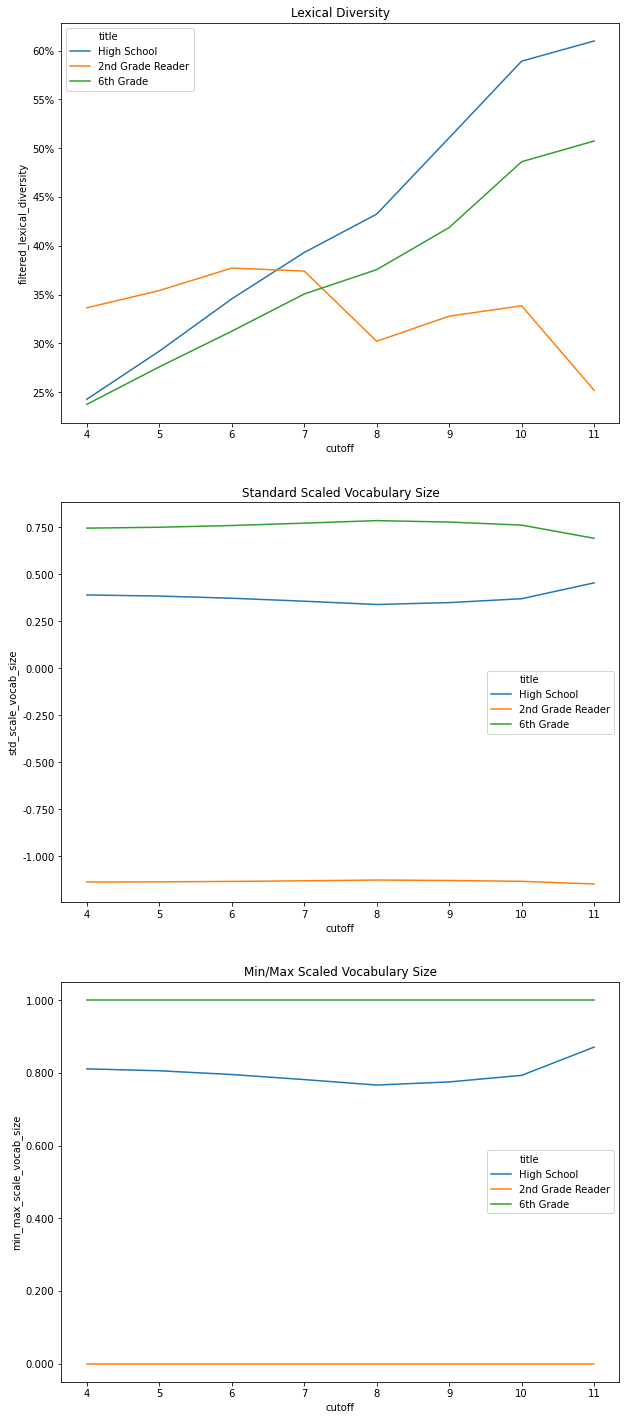

<Figure size 1440x720 with 0 Axes>

In [214]:
compare_texts([{
    'url': 'http://www.gutenberg.org/files/50543/50543-0.txt',
    'title': 'High School',
    'start_text': 'HOW THIS BOOK MAY BE USED'
}, {
    'url': 'http://www.gutenberg.org/files/15659/15659.txt',
    'title': '2nd Grade Reader',
    'start_text': 'CONTENTS'
}, {
    'url': 'http://www.gutenberg.org/files/16751/16751.txt',
    'title': '6th Grade',
    'start_text': 'SELECTIONS FOR READING. (5)'
}],
              text_min=4,
              text_max=12)

#### Summary:

Overall, scaling the vocabulary score, whether via min/max or via standard scaling - the results were the same (simplest to most complex):

- 2nd Grade
- High School 
- 6th Grade

It appears that the best metric for distinguishing the complexity of text A to text B is the lexical diversity chart as a function of word size cutoff. At lower levels - there isn't a huge difference in the lexical diversity as a function of cutoff - at higher cutoffs, it is clear that the high school and 6th grade texts are more complex as we raise the cutoff. 

What this implies, is that the richess of words continually increases for the - assumed - more sophisticated works (6th grade and HS). The scaling was able to distinguish between simple text and more complex, but it could not distinguish between 6th and HS. Ideally, a simple visual inspection of the first chart above could assist in determining the reading level of a particular text. 